# Capstone Project: Books recommender system

### Overall Contents:
- Background
- Data Collection
- Data Cleaning Books Interactions
- Data Cleaning Booklist
- [Exploratory Data Analysis](#5.-Exploratory-Data-Analysis) **(In this notebook)**
* Non-personalized recommendation
    - Modeling 1 Popularity-based and Content-based recommendation system 
* Personalized recommendation
    - Modeling 2 Collaborative-filtering-based recommendation system
    - Modeling 3 Clustering-Collaborative-filtering-based recommendation system
    - Modeling 4 Model-based recommendation systems
- Evaluation
- Conclusion and Recommendation

### Datasets

The dataset are obtained from [University of California San Diego Book Graph](https://sites.google.com/eng.ucsd.edu/ucsdbookgraph/home?authuser=0).

The dataset contains meta-data of books and user-book interactions.

Meta-data of books:-
* booklist_compiled
* booklist_works
* booklist_authors
* booklist_series
* series_list_df
* multiple_authors_name_df
* genrebook_interactions

User-book interactions:-
* booklist_interactions
* user_work_interactions

For more details on the datasets, please refer to the data_dictionary_clean.ipynb.

## 5. Exploratory Data Analysis

### 5.1 Libraries Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
from plot_graphs import plot_boxplot, plot_barplot, numeric_plot_histplot, dataframe_plot, plot_countplot

%config InlineBackend.figure_format = 'retina'
%matplotlib inline 

# Maximum display of columns
pd.options.display.max_colwidth = 2000
pd.options.display.max_rows = 2000

### 5.2 Data Import

In [2]:
booklist_compiled = pd.read_parquet("../data/booklist_compiled_clean.parquet") 
booklist_interactions = pd.read_parquet("../data/booklist_interactions_clean.parquet")
booklist_works = pd.read_parquet("../data/booklist_works_clean.parquet")
booklist_authors = pd.read_parquet("../data/booklist_authors.parquet")
booklist_series = pd.read_parquet("../data/booklist_series_clean.parquet")
user_work_interactions = pd.read_parquet("../data/user_work_interactions.parquet")
genrebook_interactions = pd.read_parquet("../data/genrebook_interactions_model.parquet")
series_list_df = pd.read_parquet("../data/series_list_df.parquet") 
multiple_authors_name_df = pd.read_parquet("../data/multiple_authors_name_df.parquet") 

### 5.3 Data exploratory analysis

1. Books
2. Authors
3. Readers

### 5.3.1 Books

* Genres
* Book series
* Book editions
* Distribution of the number of pages a book has
* The distribution of years that a book originally published
* The languages of the books present in goodreads
* The format of the books present in goodreads
* The published of the books present in goodreads
* Goodreads book ratings

### 5.3.1.1 Book Genres

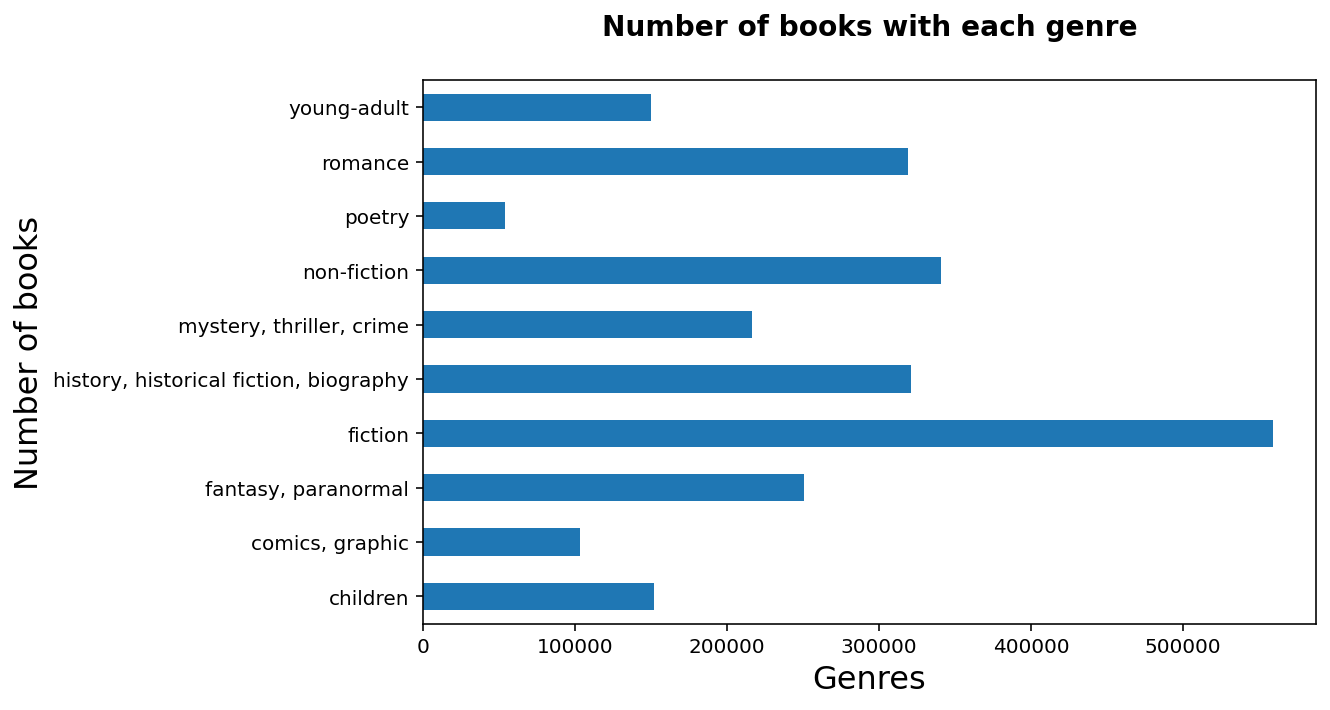

In [3]:
dataframe_plot(genrebook_interactions.count(), 'barh', "Number of books with each genre","Genres", "Number of books")

**Analaysis: Out of the 10 genres, most of the books are indicated as fiction by the users.**

Although a book can have a few genres, many of the books are indicated as fiction by the users with poetry genre being the least.

**Book Series**

In [4]:
# Matches the work_id of the user_work_interactions in series_list_df
user_work_interactions_series = user_work_interactions.drop(["user_id", "rating"], axis = 1)
user_work_interactions_series = user_work_interactions_series.drop_duplicates()
series_list_df = series_list_df.drop(["book_id"], axis = 1)
series_list_df = series_list_df.drop_duplicates(subset=["work_id"])
series_list_df = series_list_df.rename({"series": "series_id"}, axis = 1)
series_list_df["presence"] = series_list_df.work_id.isin(user_work_interactions_series.work_id).astype(int)
series_list_df.presence.value_counts()

1    368704
0      1985
Name: presence, dtype: int64

In [5]:
# To ensure series_list_df only have work_id in user_work_interactions
series_list_df = series_list_df[series_list_df["presence"] == 1]
series_list_df = series_list_df.drop(["presence"], axis = 1)
print(f" Series_list_df shape is {series_list_df.shape}")
series_list_df.head()

 Series_list_df shape is (368704, 2)


,work_id,series_id
0,8948723,189911
1,701117,151854
2,6243149,169353
3,54143148,1052227
4,41333541,1070125


In [6]:
# Integrate the work_id in booklist_series and only contains work_id in user_work_interactions
booklist_series = pd.merge(booklist_series, series_list_df, on = "series_id", how = 'left')
booklist_series = booklist_series[booklist_series.work_id.notnull()]
booklist_series.work_id = booklist_series.work_id.astype(int)
booklist_series.head()

,numbered,title,series_works_count,series_id,primary_work_count,work_id
0,1,Sun Wolf and Starhawk,9,189911,3,8948723
1,1,Avalon: Web of Magic,14,151854,12,701117
2,1,Crowner John Mystery,15,169353,15,6243149
3,1,Pluto's Snitch,3,1052227,3,54143148
4,0,"The Way, With The Enchanted Neighborhood",3,1070125,3,41333541


In [7]:
booklist_series.numbered.value_counts()

1    332460
0     36244
Name: numbered, dtype: int64

**Analysis: There are 332460 books that are in the series with 36244 which is not.**

In [8]:
# Summary statistics of the primary work count (The number of books listed in the book series list excluding editions)
booklist_series[booklist_series.numbered == 1].describe()[["numbered", "primary_work_count"]]

,numbered,primary_work_count
count,332460.0,332460.000000
mean,1.0,12.979925
std,0.0,39.335682
min,1.0,0.000000
25%,1.0,3.000000
50%,1.0,5.000000
75%,1.0,9.000000
max,1.0,738.000000


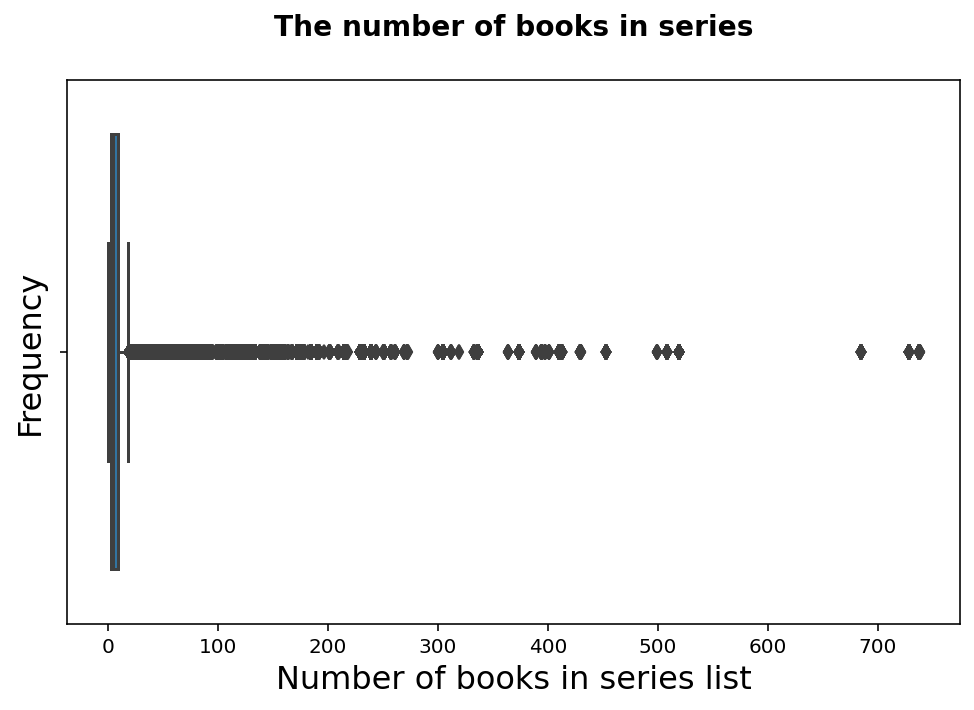

In [9]:
plot_boxplot(booklist_series[booklist_series.numbered == 1], 'primary_work_count', None, None, "The number of books in series", "Number of books in series list", "Frequency", 'h')

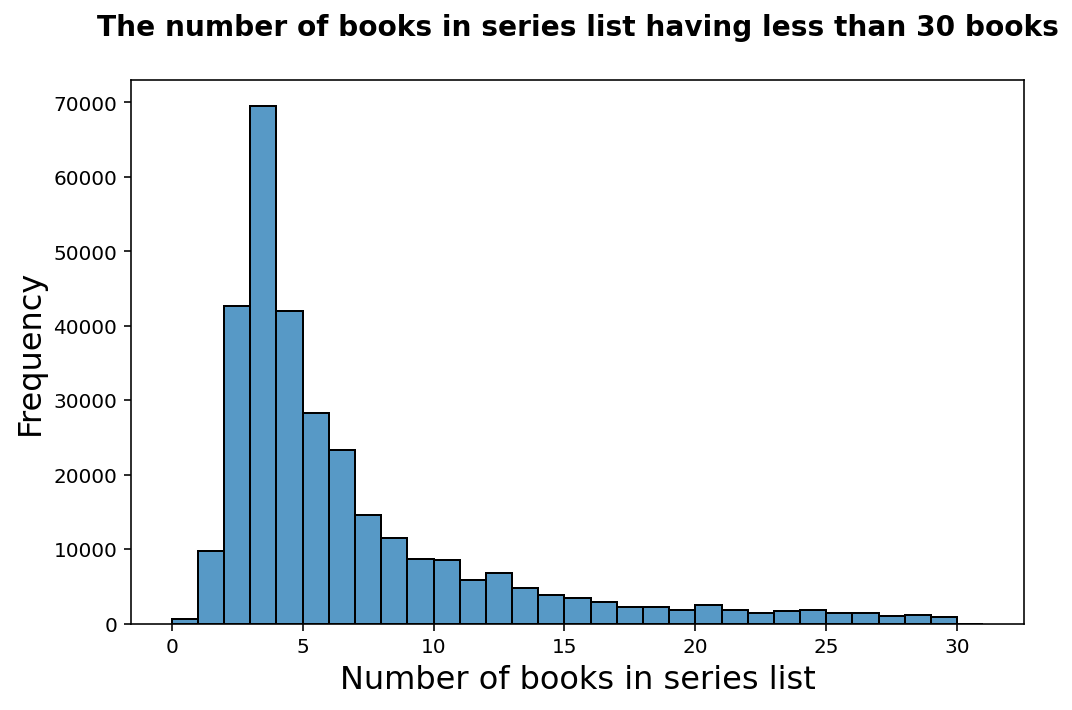

In [10]:
numberedbooks = booklist_series[booklist_series.numbered == 1]
numeric_plot_histplot(numberedbooks[numberedbooks.primary_work_count<30], 'primary_work_count', 30, 1, (0,31), "The number of books in series list having less than 30 books", "Number of books in series list", "Frequency")

**Analysis: The number of books in a series range from 0 to 738 books (excluding book editions) Majority of the book series have less than 10 books in a series, with majority of them having about 3 books.**

### 5.3.1.2 Book Edition

In [11]:
user_work_interactions_series.work_id.isin(booklist_works.work_id).value_counts()

True    1500251
Name: work_id, dtype: int64

In [12]:
# Matches the work_id of the user_work_interactions in booklist_works
booklist_works["presence"] = booklist_works.work_id.isin(user_work_interactions_series.work_id).astype(int)
booklist_works.presence.value_counts()

1    1500251
0      21711
Name: presence, dtype: int64

In [13]:
booklist_works.presence.value_counts()

1    1500251
0      21711
Name: presence, dtype: int64

In [14]:
# Integrate the work_id in booklist_works and only contains work_id in user_work_interactions
booklist_works = booklist_works[booklist_works.presence == 1]
booklist_works = booklist_works.drop(["presence"], axis = 1)
booklist_works.shape

(1500251, 14)

In [15]:
booklist_works.describe()[["books_count"]]

,books_count
count,1.500251e+06
mean,4.586756e+00
std,1.730860e+01
min,1.000000e+00
25%,1.000000e+00
50%,2.000000e+00
75%,4.000000e+00
max,3.676000e+03


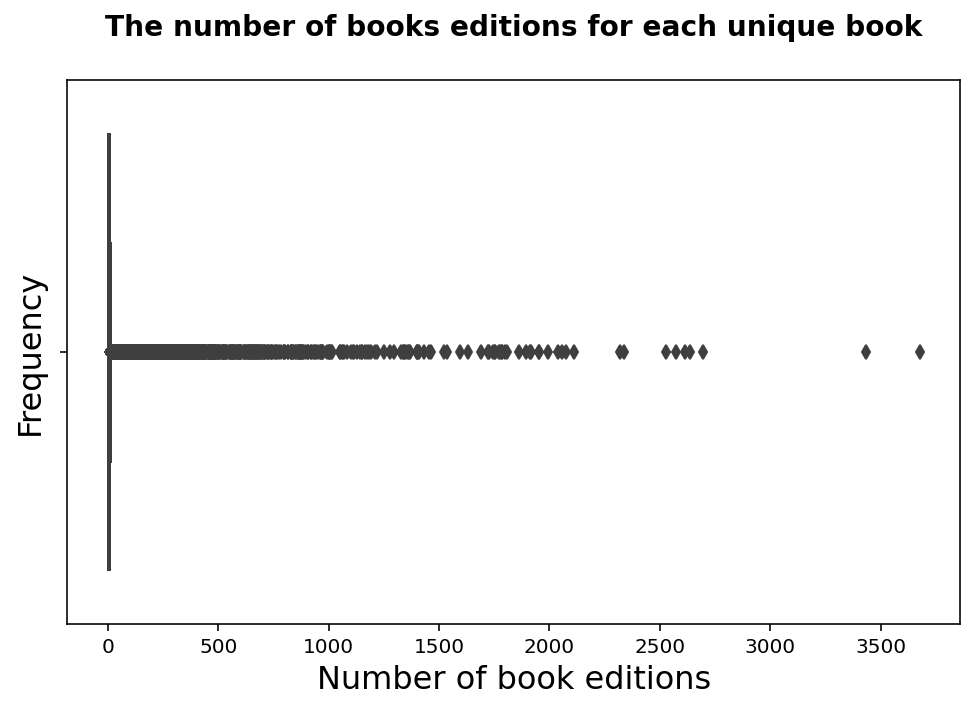

In [16]:
plot_boxplot(booklist_works, 'books_count', None, None, "The number of books editions for each unique book", "Number of book editions", "Frequency", 'h')

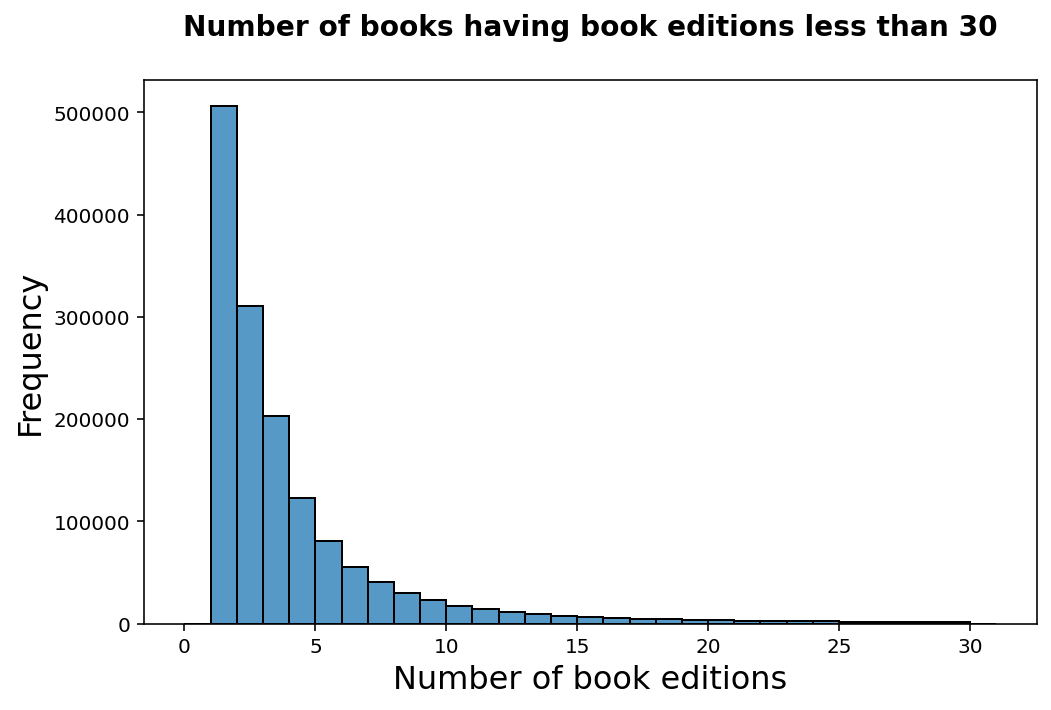

In [17]:
numeric_plot_histplot(booklist_works[booklist_works.books_count<30], 'books_count', 30, 1, (0,31), "Number of books having book editions less than 30", "Number of book editions", "Frequency")

**Analysis: A book has about 1-3676 book editions with majority of the books having less than 10 book editions, which is having only 1 book edition.**

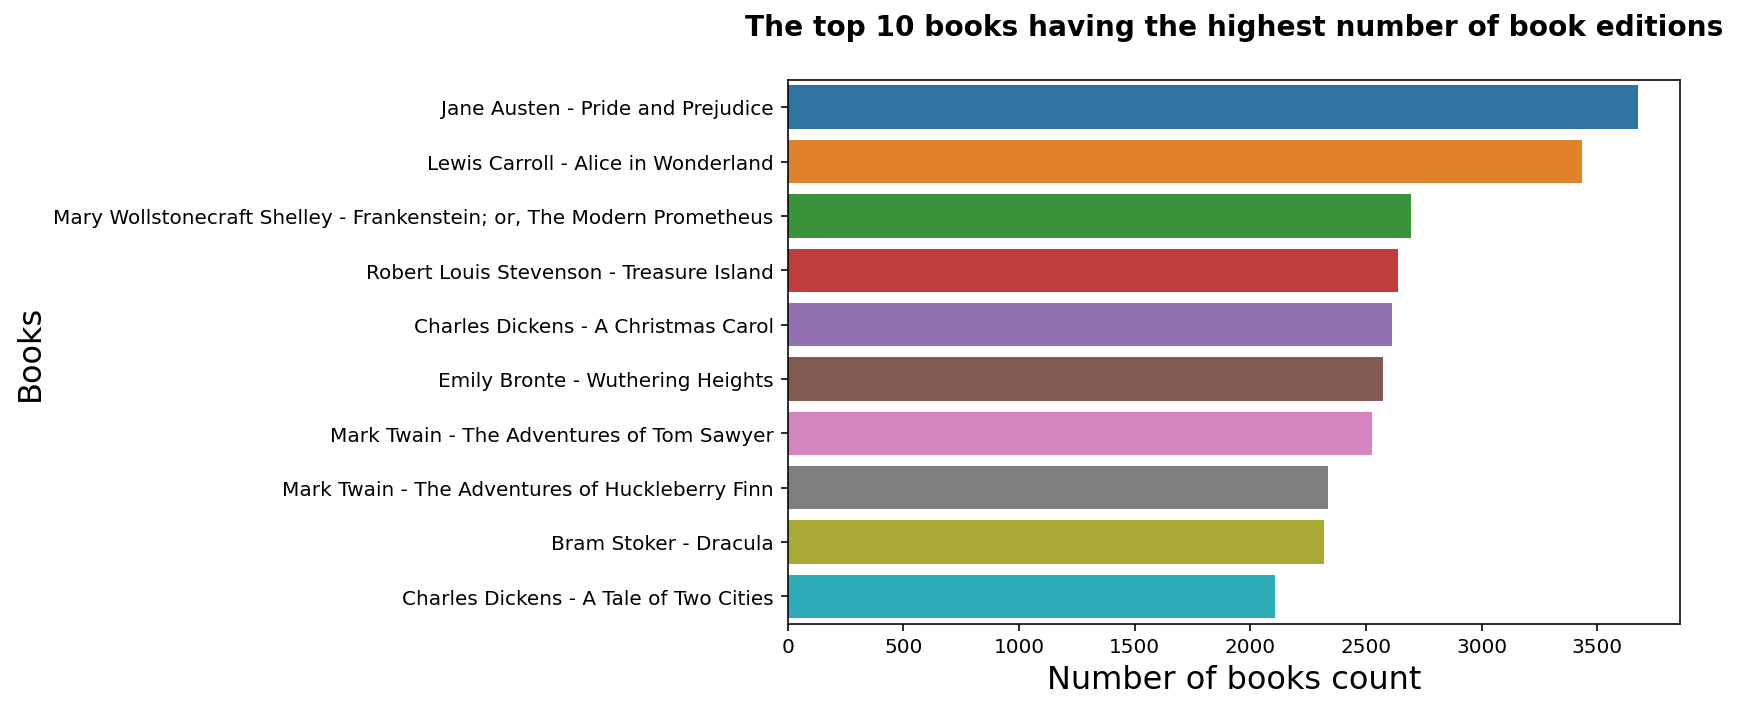

In [18]:
plot_barplot(booklist_works.sort_values(by=["books_count"],ascending = False).head(10),'books_count','first_author_title', None,"The top 10 books having the highest number of book editions", "Number of books count","Books",'h')

**Analysis: The top 2 books having the highest number of book editions with more than 3000 book editions are Pride and Prejudice, and Alice in Wonderland.**

### 5.3.1.3 Distribution of the number of pages a book has

In [19]:
user_work_interactions_series.work_id.isin(booklist_compiled.work_id).value_counts()

True    1500251
Name: work_id, dtype: int64

In [20]:
# Matches the work_id of the user_work_interactions in booklist_compiled
booklist_compiled["presence"] = booklist_compiled.work_id.isin(user_work_interactions_series.work_id).astype(int)
booklist_compiled.presence.value_counts()

1    2338284
0      21847
Name: presence, dtype: int64

In [21]:
# Integrate the work_id in booklist_compiled and only contains work_id in user_work_interactions
booklist_compiled = booklist_compiled[booklist_compiled.presence == 1]
booklist_compiled = booklist_compiled.drop(["presence"], axis = 1)
booklist_compiled.shape

(2338284, 19)

In [22]:
book_pages = booklist_compiled[booklist_compiled.num_pages!=""]
book_pages.loc[:,["num_pages"]] = book_pages.num_pages.astype(int)
book_pages.describe()[["num_pages"]]

C:\Users\cxliew\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,num_pages
count,1.582946e+06
mean,2.638768e+02
std,8.329848e+02
min,0.000000e+00
25%,1.480000e+02
50%,2.460000e+02
75%,3.440000e+02
max,9.450770e+05


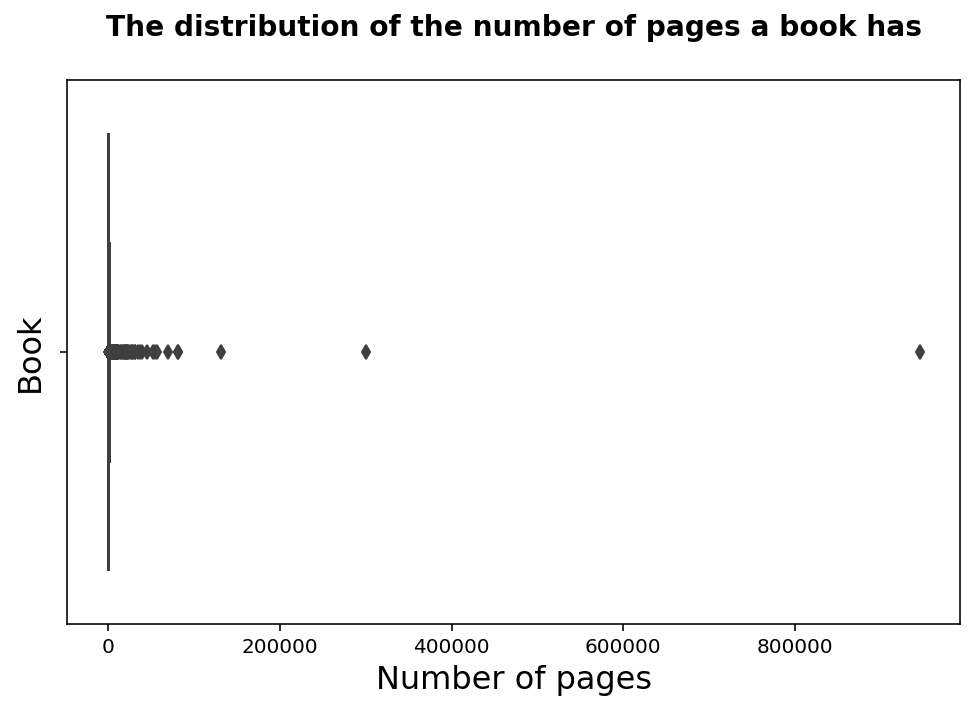

In [23]:
plot_boxplot(book_pages, 'num_pages', None, None, "The distribution of the number of pages a book has", "Number of pages", "Book", 'h')

In [24]:
book_pages[book_pages.num_pages==0][["format", "num_pages", "work_id", "first_author_title"]]

,format,num_pages,work_id,first_author_title
332,Audio,0,10958266,"Lauren Kate - Passion (Fallen, #3)"
839,,0,6966233,"Sherrilyn Kenyon - Invincible (Chronicles of Nick, #2)"
1027,ebook,0,14293435,"Kate Willoughby - Once Upon A Kiss (Be-Wished, #3)"
1177,Audiobook,0,23589581,Michael J. Sullivan - The Rose and the Thorn (The Riyria Chronicles #2)
1631,,0,16880582,Sugar Lee Ryder - Adam's Bar-b-Que Ribs
...,...,...,...,...
2358439,Audio CD,0,10644,Laurie Notaro - Autobiography of a Fat Bride: True Tales of a Pretend Adulthood
2358965,Audio CD,0,1806301,"Robert B. Parker - Hugger Mugger (Spenser, #27)"
2359307,,0,2710546,Atul Gawande - Complications: A Surgeon's Notes on an Imperfect Science
2359771,Audio CD,0,172576,Catherine Allgor - A Perfect Union: Dolley Madison and the Creation of the American Nation


In [25]:
book_pages[book_pages.num_pages>200000][["format", "num_pages", "work_id", "first_author_title"]]

,format,num_pages,work_id,first_author_title
18033,Kindle Edition,945077,762000,Erin McKean - The New Oxford American Dictionary
1104003,,300000,15841746,mHmd lkrbsy - دائرة المعارف الحسينية


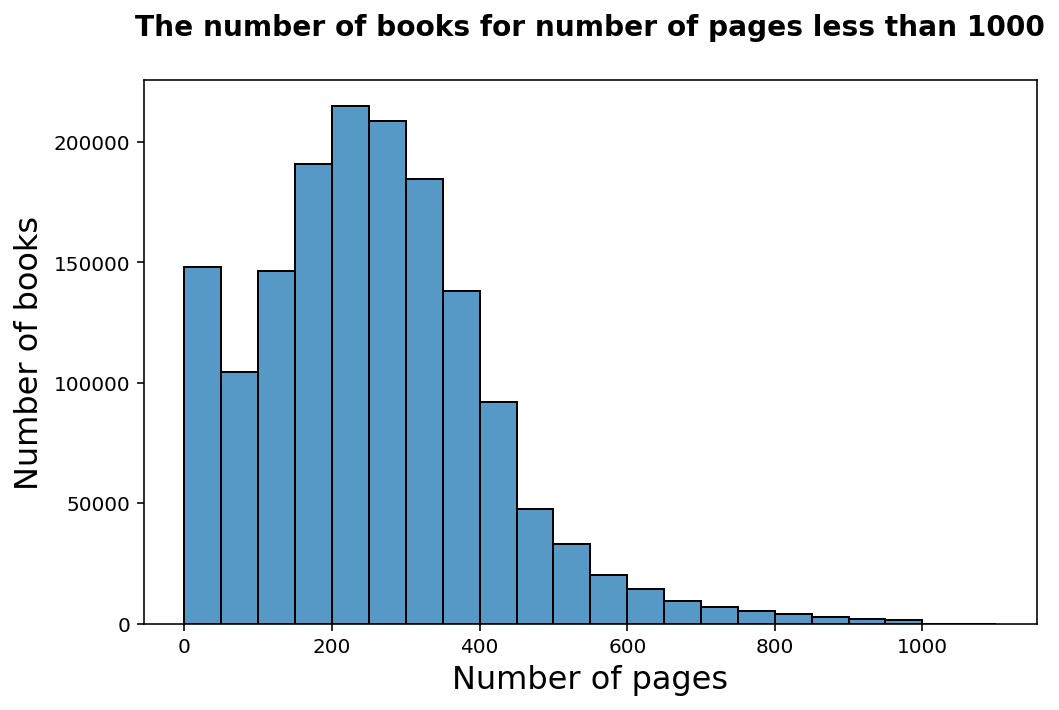

In [26]:
numeric_plot_histplot(book_pages[book_pages.num_pages<1000],'num_pages', 22, 50, (0,1100), "The number of books for number of pages less than 1000", "Number of pages", "Number of books")

**Analysis: A book has about 0-945077 pages with majority of the books 150-350 pages.**

The books having 0 pages are mainly Audio CD, ebook or there is no information on the number of pages for that book. On the other hand, the books having more than 300 thousand pages are religious book or dictionary.

### 5.3.1.4 The distribution of years that a book originally published

C:\Users\cxliew\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


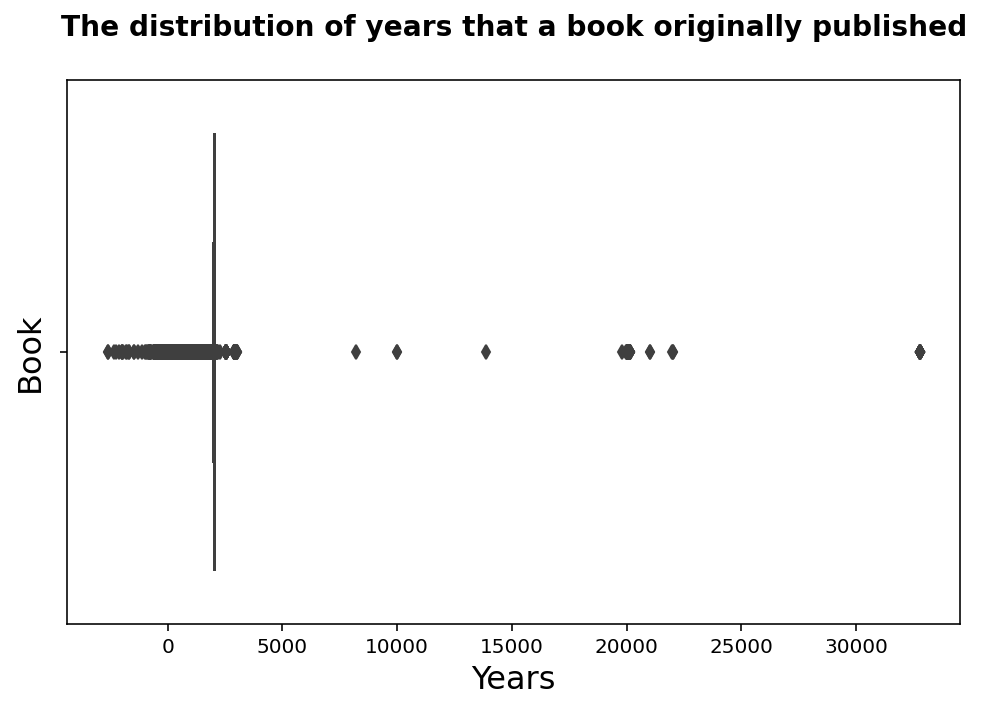

In [27]:
book_year = booklist_works[booklist_works.original_publication_year != ""]
book_year.loc[:,["original_publication_year"]] = book_year.original_publication_year.astype(int)
book_year.original_publication_year.dtypes
plot_boxplot(book_year, "original_publication_year", None, None, "The distribution of years that a book originally published", "Years", "Book", 'h')

In [28]:
book_year.describe()[["original_publication_year"]]

,original_publication_year
count,1.252783e+06
mean,2.000831e+03
std,1.788079e+02
min,-2.600000e+03
25%,2.001000e+03
50%,2.010000e+03
75%,2.013000e+03
max,3.276700e+04


**Analysis: There are books that are published prior to BC (indicated as negative value), while some books that are beyond the data collection year (2017).**

A brief check with goodreads website and amazon, there are books that are originally published prior to BC (indicated as negative value) is as reflected in both goodreads and amazon. However, this does not preclude the published year of some books could be an error in goodreads. On the other hand, the books beyond the current year are found to be present in amazon that are indicated to be published in recent years. Thus, the published year for these books could be a typo error in goodreads system (as reflected in goodreads system as well).

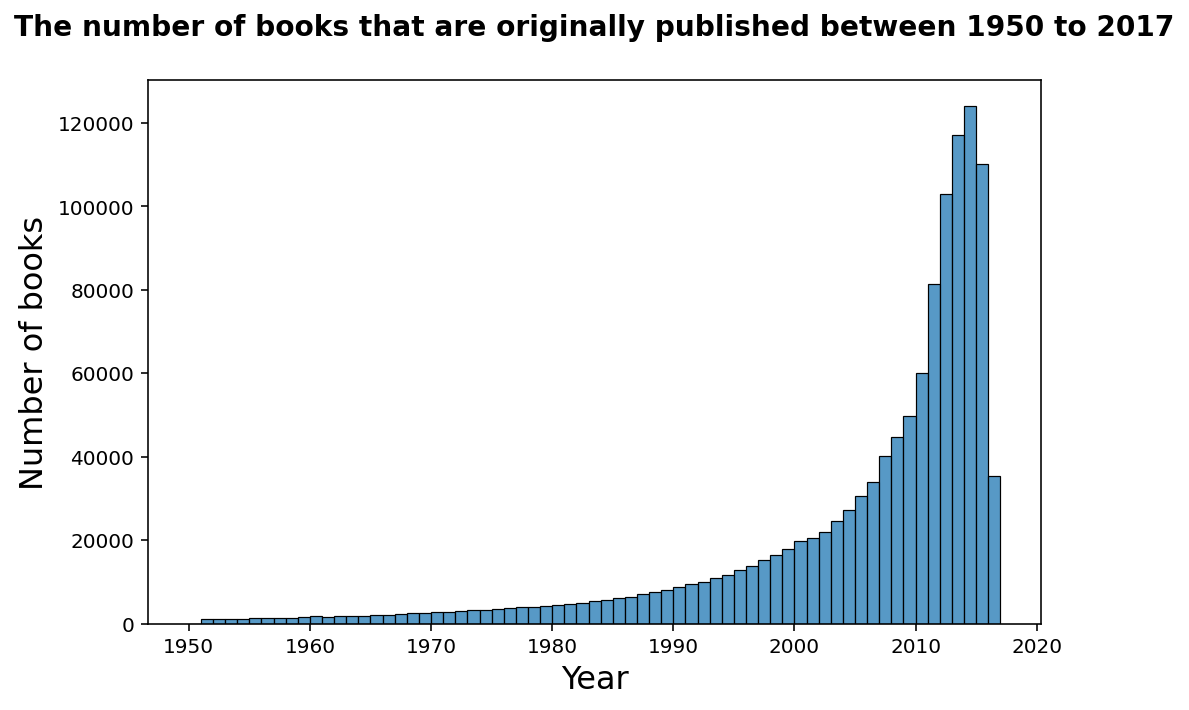

In [29]:
numeric_plot_histplot(book_year[(book_year.original_publication_year>1950) & (book_year.original_publication_year<2017)],'original_publication_year', 68, 1, (1950,2017), "The number of books that are originally published between 1950 to 2017", "Year", "Number of books")

**Analysis: There is an increasing trend in the books published from 1950 to recent years(21st century).**

Year 2015 has the highest number of books published. As the goodreads data collection was performed in late 2017, this might suggests the low number of books observed in the year 2017.

### 5.3.1.5  The languages of the books present in goodreads

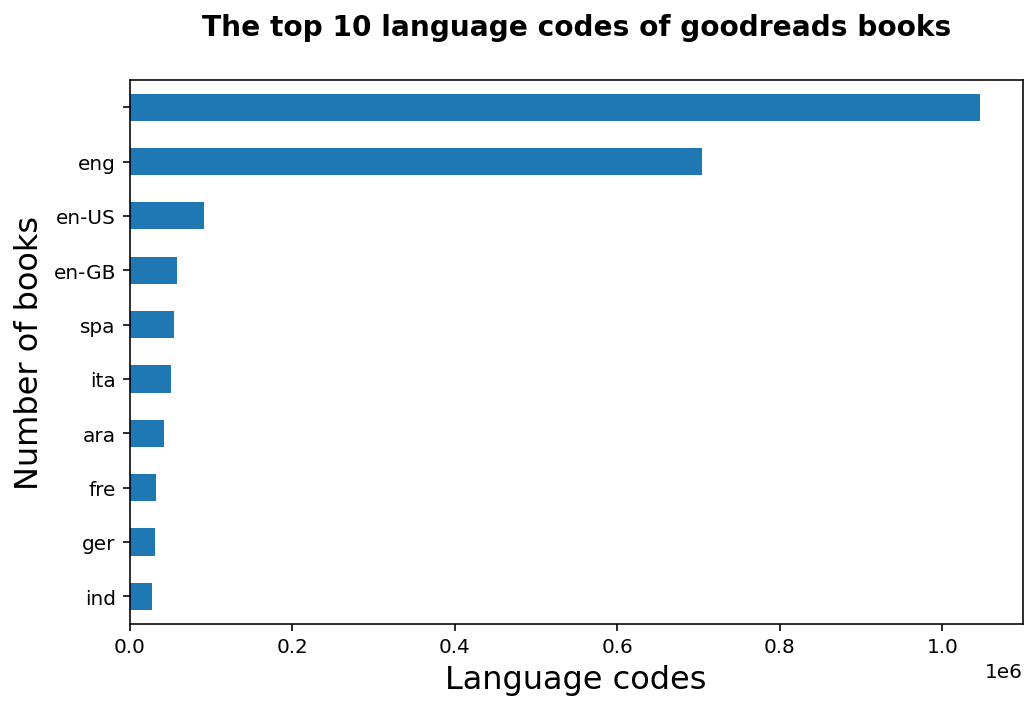

In [30]:
dataframe_plot(booklist_compiled.groupby("language_code").size().sort_values(ascending = False).head(10)[::-1], 'barh', "The top 10 language codes of goodreads books", "Language codes", "Number of books")

**Analysis: Majority of the books language are undefined and are english books.**

### 5.3.1.6  The format of the books present in goodreads

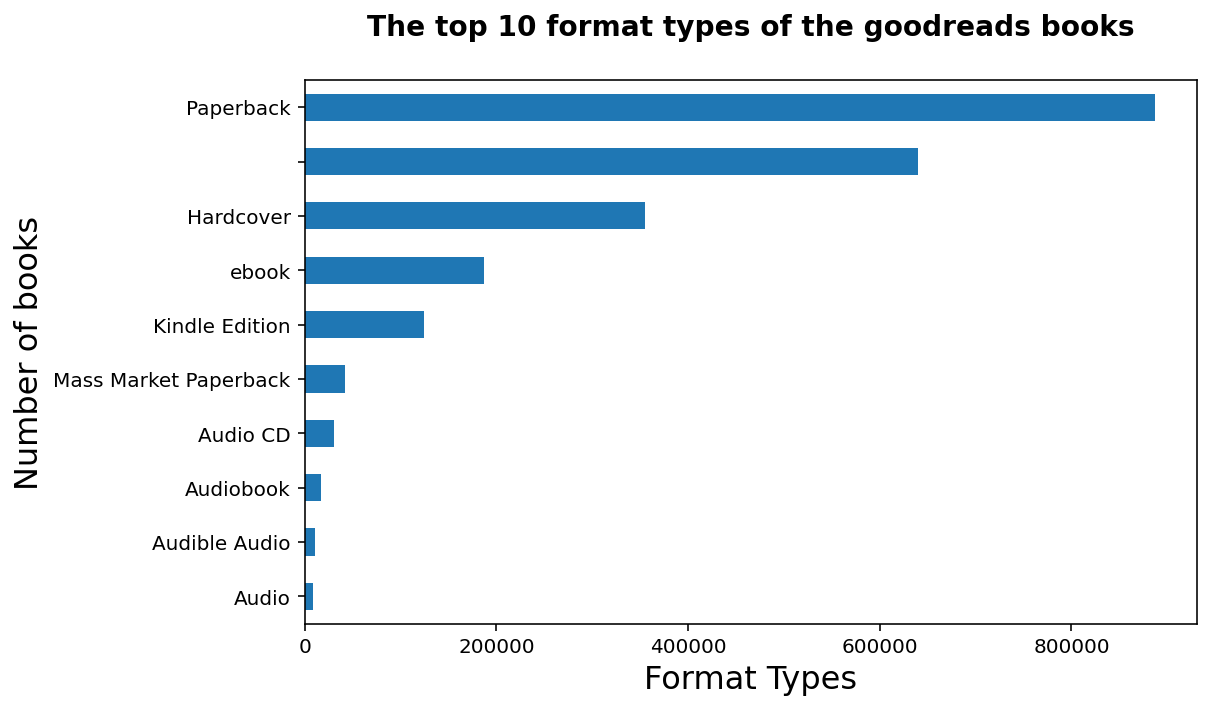

In [31]:
dataframe_plot(booklist_compiled.groupby("format").size().sort_values(ascending = False).head(10)[::-1],'barh',"The top 10 format types of the goodreads books", "Format Types", "Number of books")

**Analysis: Majority of the books format types are paperback, undefined, hardcover and ebook.**

### 5.3.1.7  The publisher of the books present in goodreads

In [32]:
booklist_compiled.groupby("publisher").size().sort_values(ascending = False)[0:10]

publisher
                                               647673
Createspace Independent Publishing Platform     18405
Smashwords Edition                              11385
Harlequin                                       10202
Createspace                                      9572
HarperCollins                                    8161
Penguin Books                                    7417
Oxford University Press, USA                     6661
Brilliance Audio                                 6347
Vintage                                          6335
dtype: int64

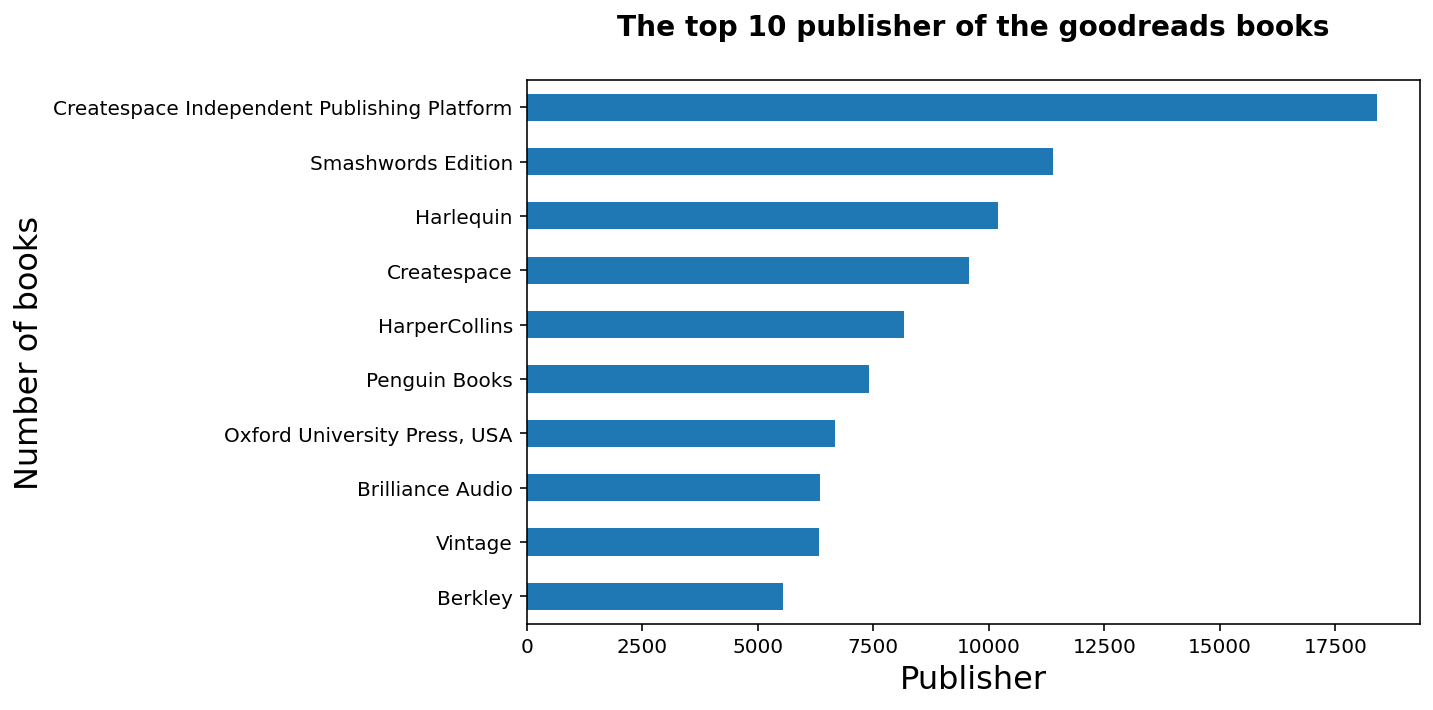

In [33]:
dataframe_plot(booklist_compiled.groupby("publisher").size()[booklist_compiled.groupby("publisher").size()<20000].sort_values(ascending = False).head(10)[::-1], 'barh','The top 10 publisher of the goodreads books',"Publisher", "Number of books")

**Analysis: Majority of the books publisher are undefined. The publisher having more than 10 thousand books in goodreads are smashwords edition, harlequin and createspace.**

### 5.3.1.8  Goodreads book ratings

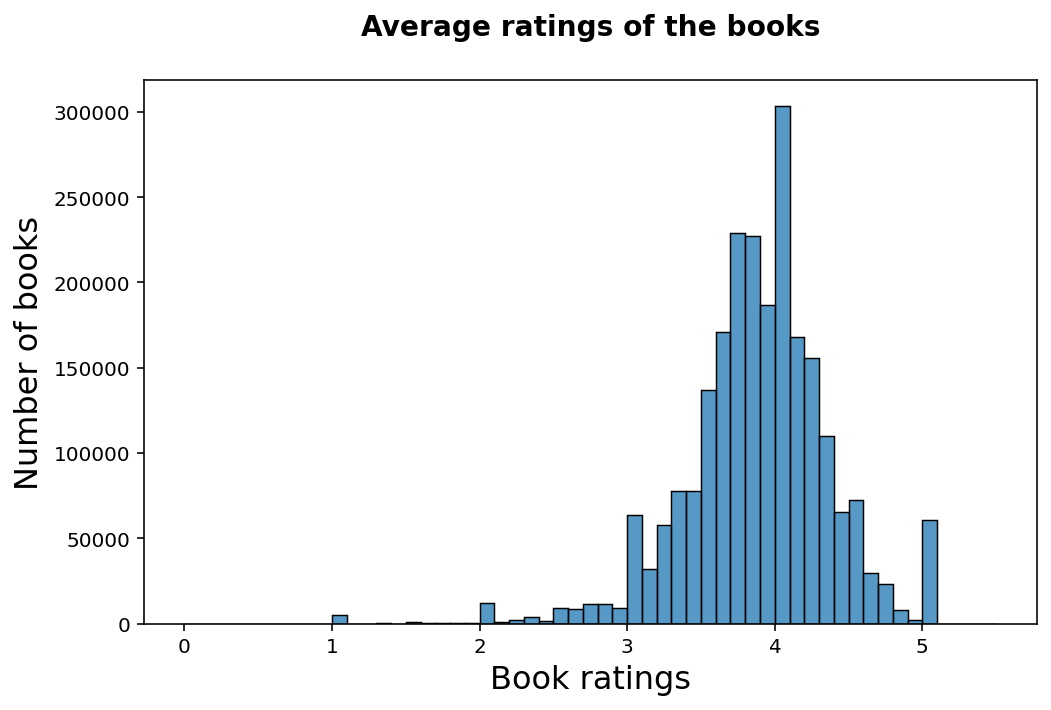

In [34]:
numeric_plot_histplot(booklist_compiled, 'average_rating', 50, 0.1, (0,5.5), "Average ratings of the books", "Book ratings", "Number of books")

**Analysis: In goodreads, majority of the books have an average rating of 4.0 with a range between 1.0 to 5.0**

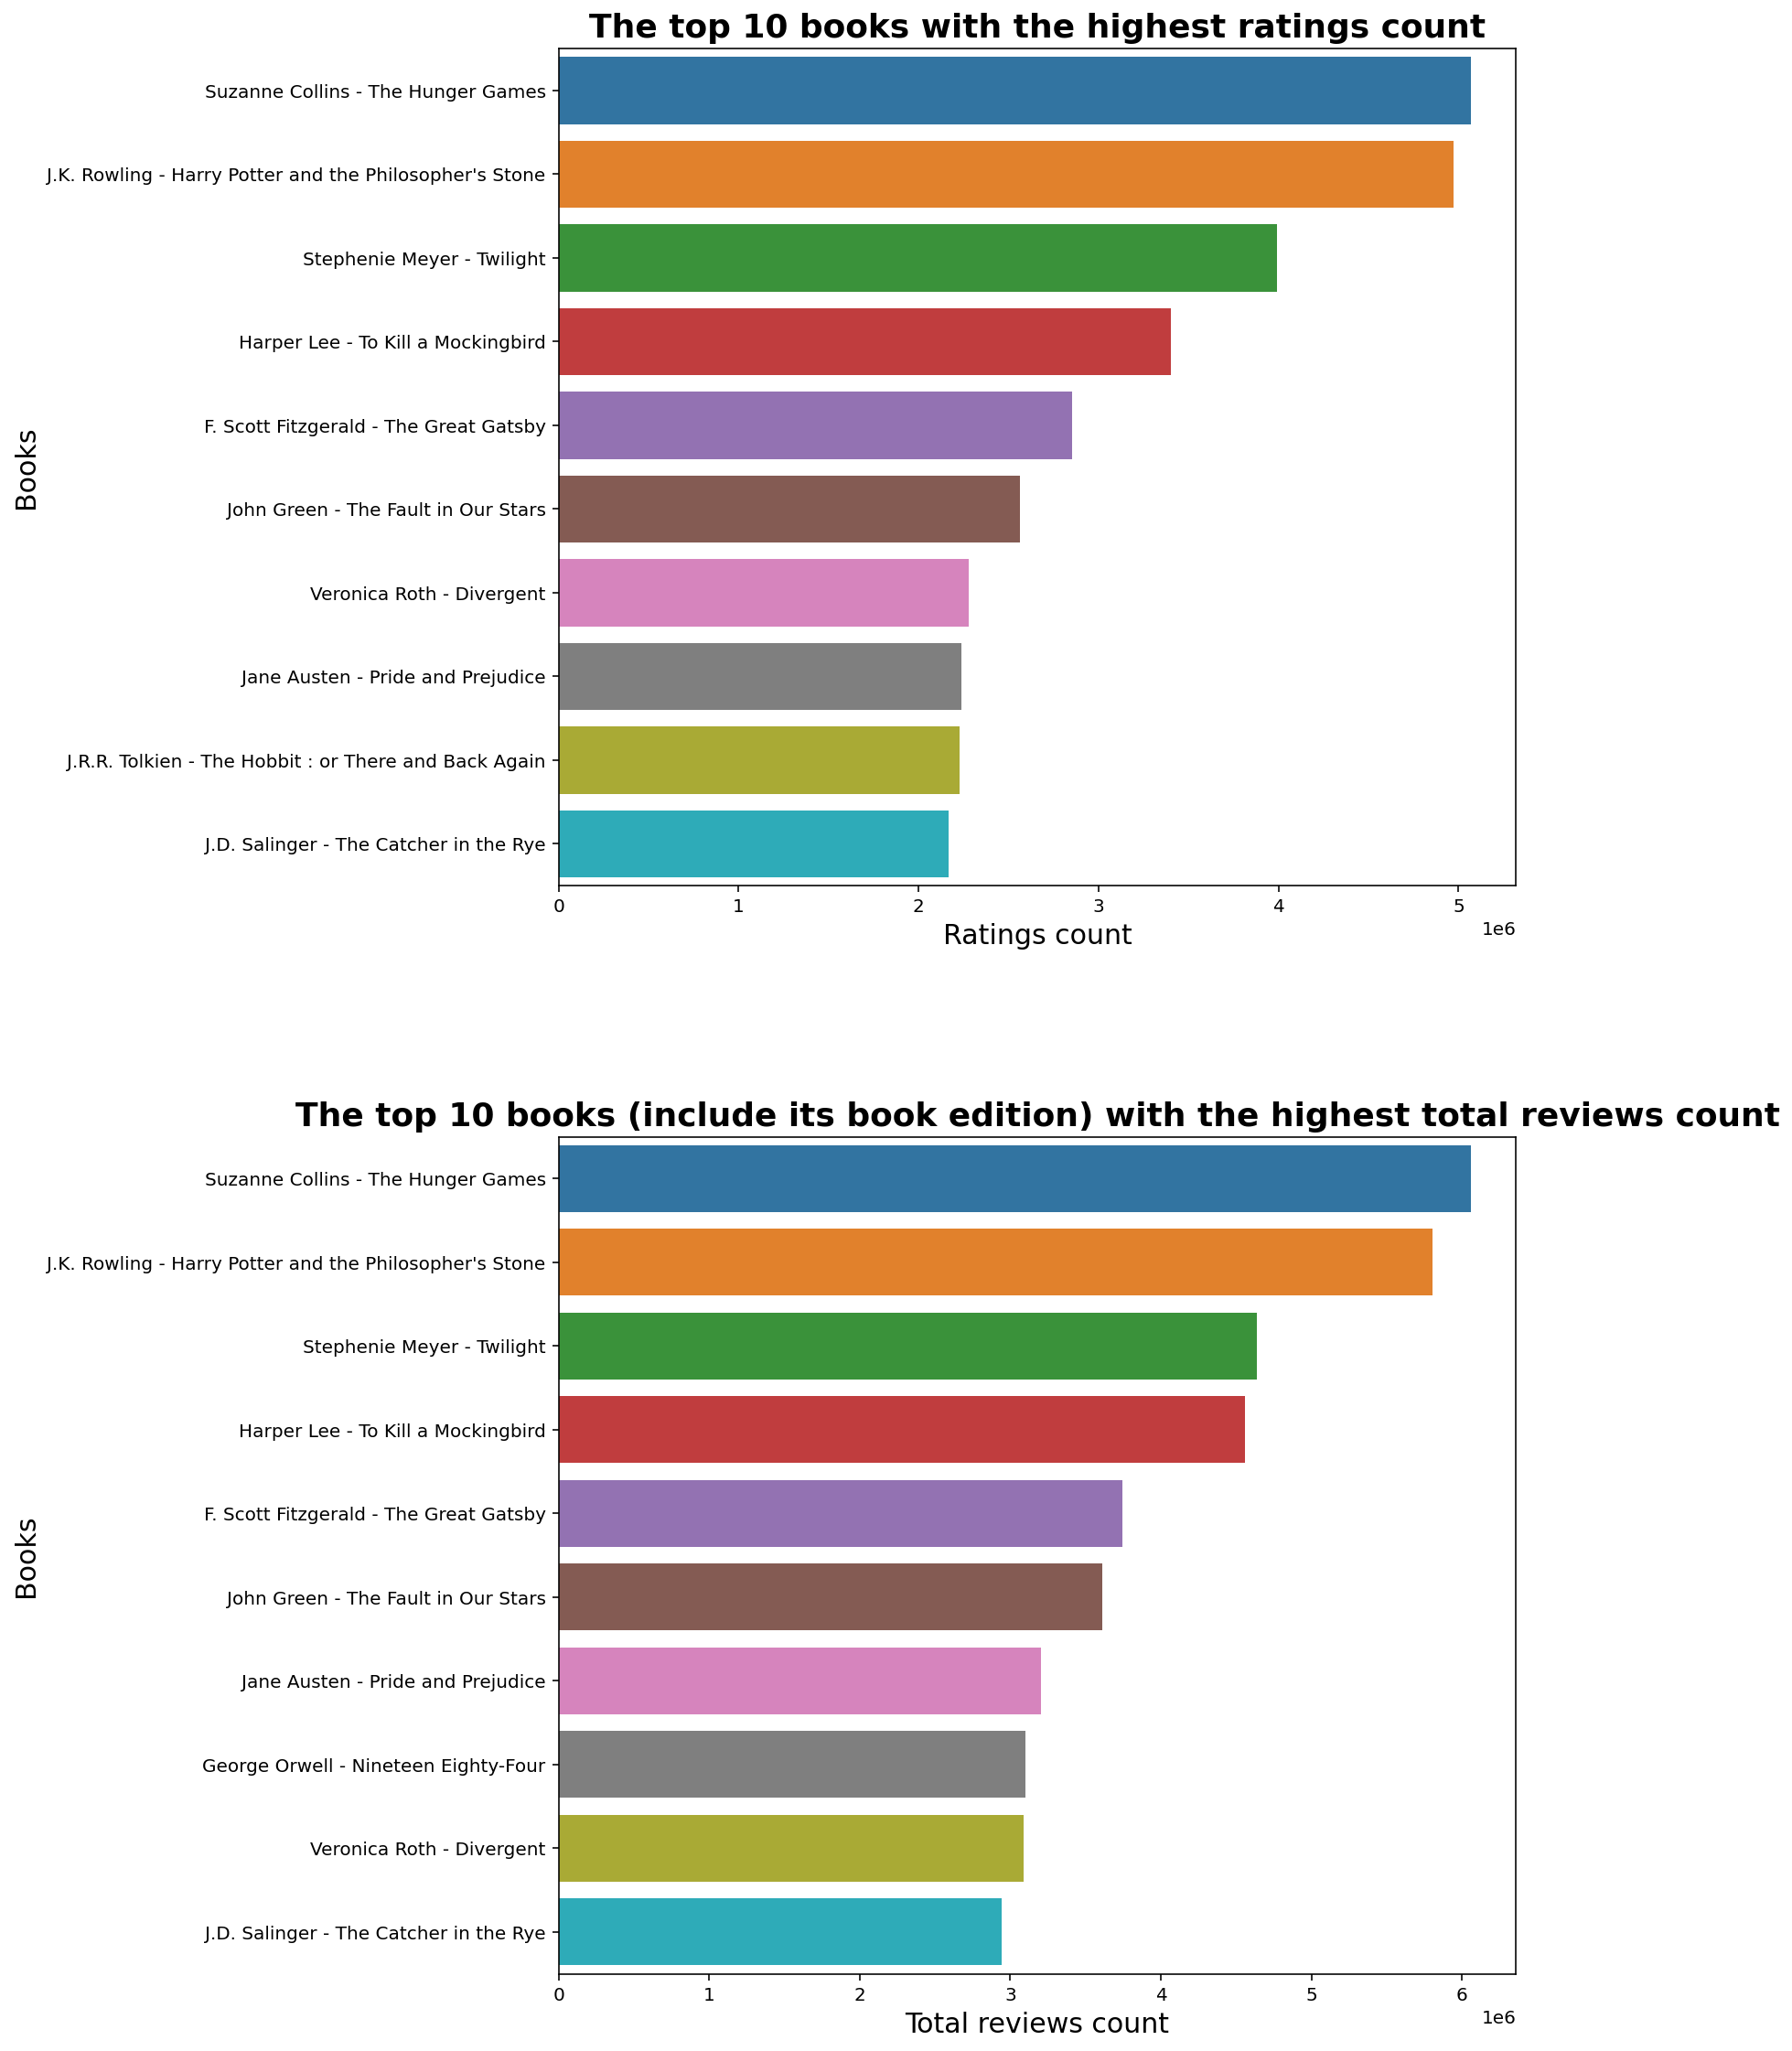

In [35]:
# Determine row and columns - for plotting and iteration 
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = [8, 5], frameon = False)
plt.tight_layout()
plt.subplots_adjust(left = None , bottom = None, right = None, top = 3.0, wspace = 0.2, hspace = 0.3)
        
# First plot
sns.barplot(x = "ratings_count", y = "first_author_title", data = booklist_works.sort_values(by="ratings_count",ascending = False).head(10), orient = 'h', ax = ax1)
ax1.set_title("The top 10 books with the highest ratings count", fontsize = 18, weight = 'bold')
ax1.set_xlabel("Ratings count", fontsize = 15)
ax1.set_ylabel("Books", fontsize = 15)

# Second plot
sns.barplot(x = "reviews_count", y = "first_author_title", data = booklist_works.sort_values(by="reviews_count",ascending = False).head(10), orient = 'h', ax = ax2)
ax2.set_title("The top 10 books (include its book edition) with the highest total reviews count", fontsize = 18, weight = 'bold')
ax2.set_xlabel("Total reviews count", fontsize = 15)
ax2.set_ylabel("Books", fontsize = 15);

**Analysis: In goodreads, the top 5 books that have the highest rating counts also has the highest total reviews count.**

The top 5 books that have both the highest rating counts and has the highest total reviews count are 
1. The Hunger Games by Suzanne Collins
2. Harry Potter and the Philopsher's stone by J.K. Rowling
3. Twilight by Stephanie Meyer
4. To kill a mockingbird by Harper Lee
5. The Great Gatsby by F.Scott Fitzgerald

This coincide with the findings that the first four books are listed as the top 100 bestselling books of all time and these top 10 books have been filmed into a movie [[1]](https://www.theguardian.com/news/datablog/2012/aug/09/best-selling-books-all-time-fifty-shades-grey-compare).

### 5.3.2 Authors

* Authors books average rating, ratings count and text_reviews_count in goodreads

In [36]:
user_work_interactions.work_id.isin(booklist_compiled.work_id).value_counts()

True    104021211
Name: work_id, dtype: int64

In [37]:
booklist_compiled.work_id.isin(user_work_interactions.work_id).value_counts()

True    2338284
Name: work_id, dtype: int64

**Analysis: All work_id are present in both user_work_interactions and booklist_compiled.**

In [38]:
# Matches the work_id of the user_work_interactions in multiple_authors_name_df
multiple_authors_name_df["presence"] = multiple_authors_name_df.work_id.isin(booklist_compiled.work_id).astype(int)
multiple_authors_name_df = multiple_authors_name_df[multiple_authors_name_df["presence"] == 1]
multiple_authors_name_df = multiple_authors_name_df.drop(["presence"], axis = 1)
multiple_authors_name_df.shape

(3294223, 6)

In [39]:
booklist_authors.author_id.isin(multiple_authors_name_df.author_id).value_counts()

True     817474
False     12055
Name: author_id, dtype: int64

In [40]:
# Integrate the work_id in booklist_authors and only contains work_id in user_work_interactions
booklist_authors['presence'] = booklist_authors.author_id.isin(multiple_authors_name_df.author_id).astype(int)
booklist_authors = booklist_authors[booklist_authors['presence'] == 1]
booklist_authors = booklist_authors.drop(["presence"], axis = 1)
booklist_authors.shape

(817474, 5)

In [41]:
booklist_authors.describe()

,average_rating,author_id,text_reviews_count,ratings_count
count,817474.000000,8.174740e+05,817474.000000,8.174740e+05
mean,3.858891,5.743431e+06,108.407911,1.618695e+03
std,0.555148,5.125379e+06,1783.184570,4.512537e+04
min,0.000000,3.000000e+00,0.000000,0.000000e+00
25%,3.590000,9.260152e+05,2.000000,9.000000e+00
50%,3.900000,4.947436e+06,6.000000,3.200000e+01
75%,4.170000,7.832830e+06,20.000000,1.350000e+02
max,5.000000,1.734337e+07,448570.000000,1.853272e+07


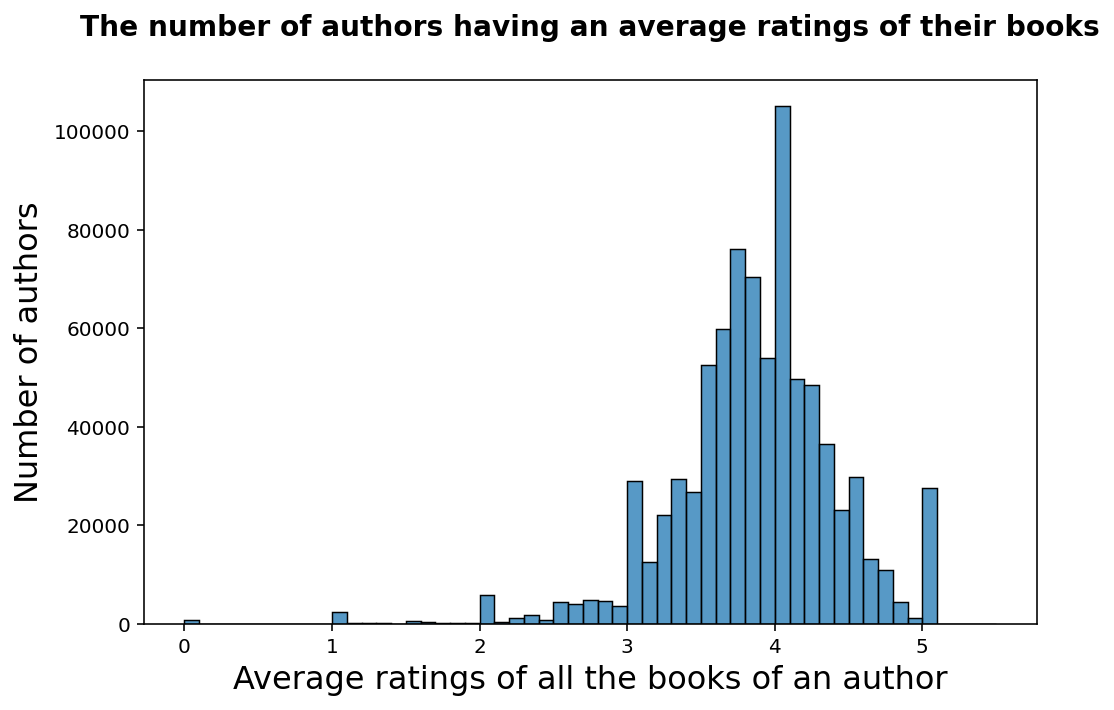

In [42]:
numeric_plot_histplot(booklist_authors,'average_rating', 50, 0.1, (0,5.5), "The number of authors having an average ratings of their books","Average ratings of all the books of an author","Number of authors")

**Analysis: In goodreads, majority of author have an average rating of 4.0 with a range between 1.0 to 5.0** 

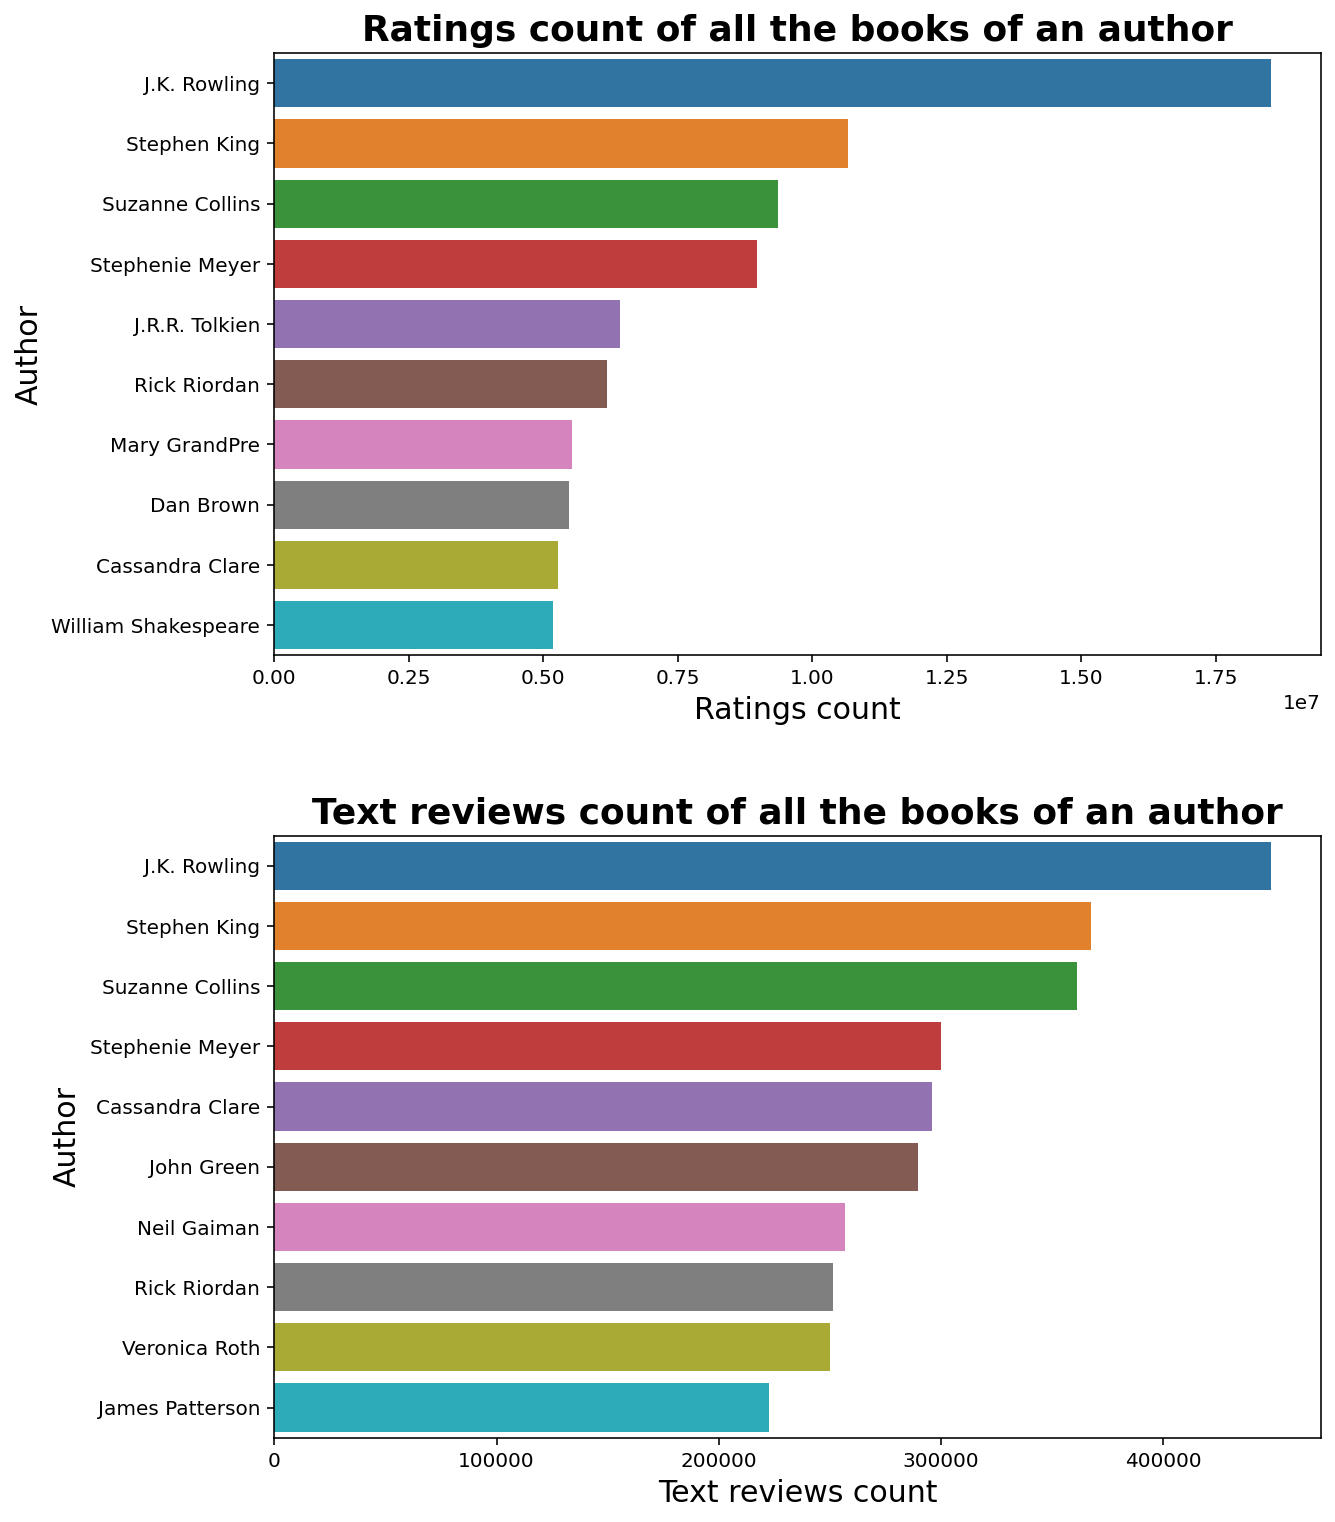

In [43]:
# Determine row and columns - for plotting and iteration 
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = [8, 5], frameon = False)
plt.tight_layout()
plt.subplots_adjust(left = None , bottom = None, right = None, top = 2.0, wspace = 0.2, hspace = 0.3)
        
# First plot (top)
sns.barplot(x = "ratings_count", y = "name", data = booklist_authors.sort_values(by="ratings_count",ascending = False).head(10), orient = 'h', ax = ax1)
ax1.set_title("Ratings count of all the books of an author", fontsize = 18, weight = 'bold')
ax1.set_xlabel("Ratings count", fontsize = 15)
ax1.set_ylabel("Author", fontsize = 15)

# Second plot (bottom)
sns.barplot(x = "text_reviews_count", y = "name", data = booklist_authors.sort_values(by="text_reviews_count",ascending = False).head(10), orient = 'h', ax = ax2)
ax2.set_title("Text reviews count of all the books of an author", fontsize = 18, weight = 'bold')
ax2.set_xlabel("Text reviews count", fontsize = 15)
ax2.set_ylabel("Author", fontsize = 15);

**Analysis: In goodreads, the top 4 authors that have the highest rating counts also has the highest total reviews count.**

The top 4 authors that have both the highest rating counts and has the highest total reviews count are 
1. J.K. Rowling
2. Stephen King
3. Suzanne Collins
4. Stephanie Meyer

This coincide with the findings that the first four authors have bestselling books. All the top 10 authors that have highest ratings counts or highest total reviews count have books that are filmed in movies.

### 5.3.3 User books interactions

For books that have been read:-
* Books reviewed by the users
* Number of unique books rated per user
* Average ratings of the books rated by the users

In [44]:
booklist_interactions.work_id.isin(user_work_interactions.work_id).value_counts()

True    104543831
Name: work_id, dtype: int64

In [45]:
user_work_interactions.work_id.isin(booklist_interactions.work_id).value_counts()

True    104021211
Name: work_id, dtype: int64

### 5.3.3.1 Books reviewed by the users

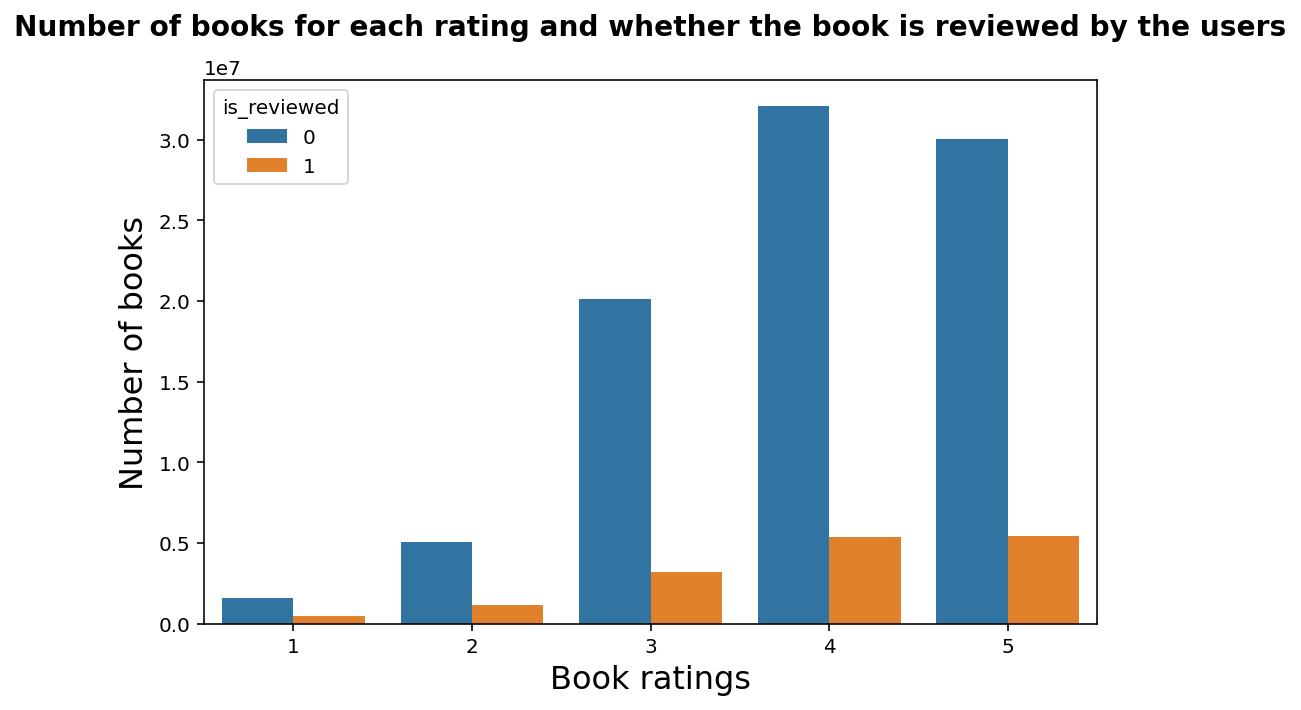

In [46]:
plot_countplot(booklist_interactions, "rating", "is_reviewed","Number of books for each rating and whether the book is reviewed by the users","Book ratings","Number of books")

**Analysis: A significant proportion of the books rated are not reviewed by the users**

### 5.3.3.2 Number of unique books rated per user

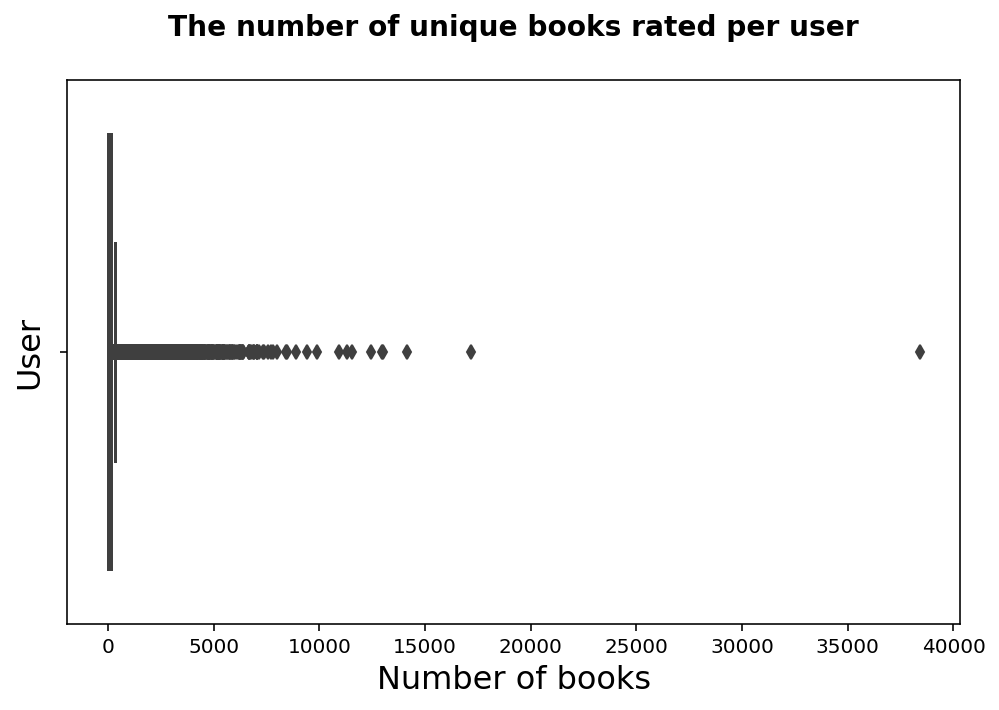

In [47]:
userbook_count = user_work_interactions.groupby(["user_id"]).size().reset_index().rename({0:"bookcount_user"}, axis = 1)
plot_boxplot(userbook_count, "bookcount_user", None, None, "The number of unique books rated per user", "Number of books", "User", 'h')

**Analysis: There is an outlier in which a user has rated more than 35000 books. Thus, this user will be removed from our user_book_interactions.**

In [48]:
# Identify the user who rated more than 20000 books
userbook_count[userbook_count.bookcount_user>20000].user_id.unique()

array([320562], dtype=int64)

In [49]:
# Removal of the user who has rated more than 20000 books
user_work_interactions = user_work_interactions[~(user_work_interactions.user_id == 320562)]

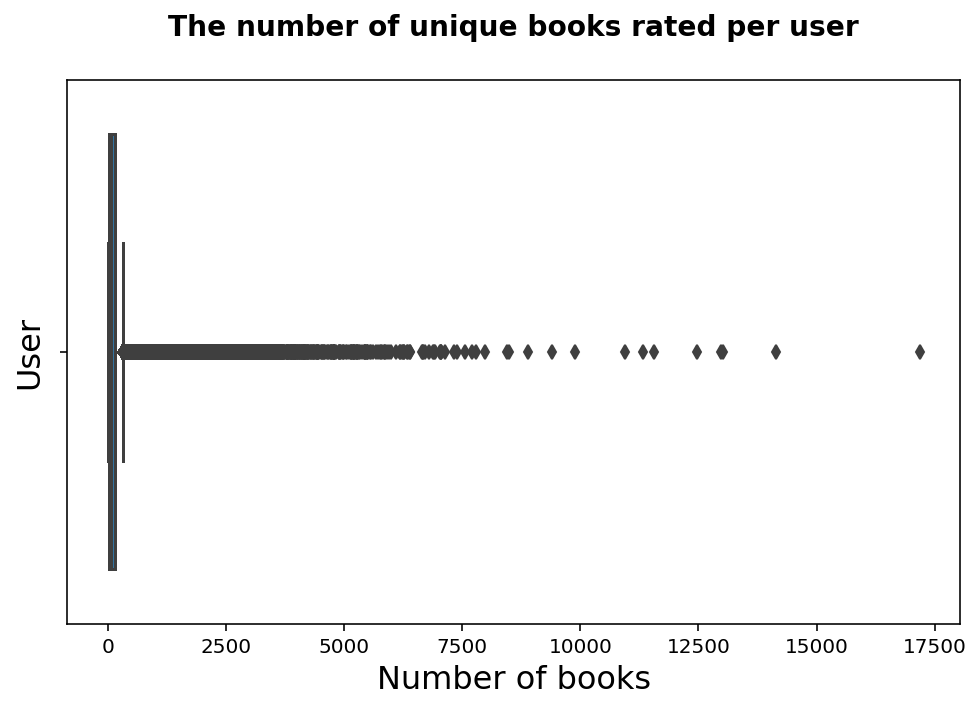

In [50]:
userbook_count = user_work_interactions.groupby(["user_id"]).size().reset_index().rename({0:"bookcount_user"}, axis = 1)
plot_boxplot(userbook_count, "bookcount_user", None, None, "The number of unique books rated per user", "Number of books", "User", 'h')

In [51]:
userbook_count.describe()

,user_id,bookcount_user
count,816368.000000,816368.000000
mean,422954.201789,127.372475
std,252453.899551,232.515655
min,0.000000,1.000000
25%,205054.750000,22.000000
50%,410316.500000,55.000000
75%,639964.250000,140.000000
max,876144.000000,17182.000000


**Analysis: Majority of the users rated the books less than 150 books with some users rated more than 7500 to 17000 books.**

As it is estimated that a person read about 1 - 23 thousand books in a lifetime, thus, more than 10000 books read per user is possible depending on the accumulative number of years the user has read, the number of pages of the book read, and the speed the user read assuming the user read finish the books before they rated any of the books.

### 5.3.3.3 Average ratings of the books rated by the users

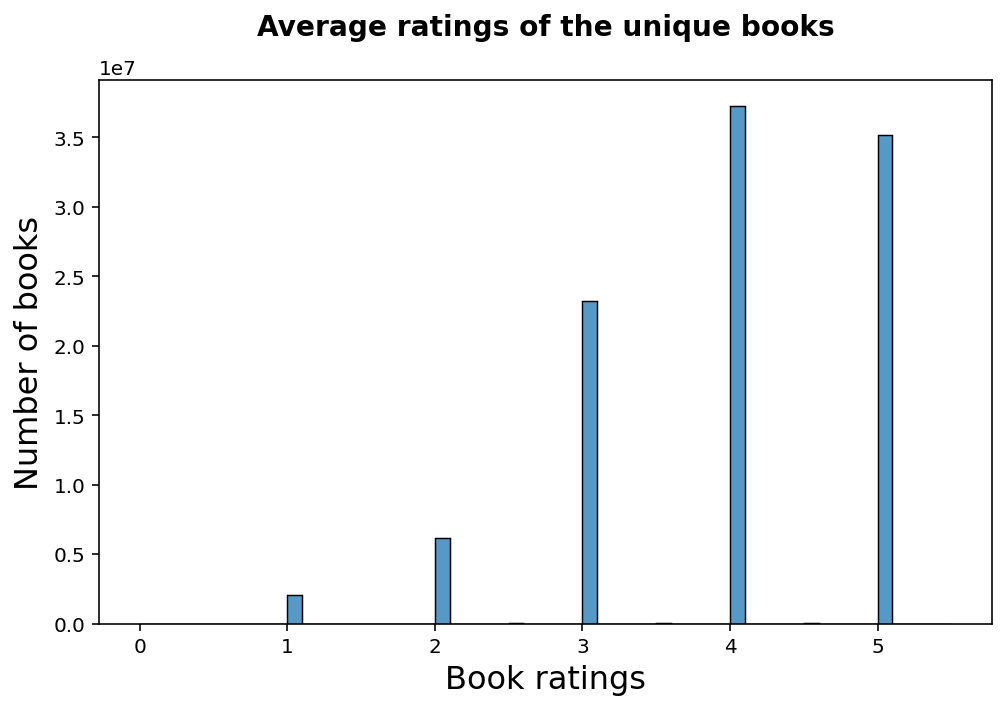

In [52]:
numeric_plot_histplot(user_work_interactions, 'rating', 50, 0.1, (0,5.5), "Average ratings of the unique books", "Book ratings", "Number of books")

**Analysis: In user book interactions, majority of user have rated the book with an average rating of 4.0 and a range between 1.0 to 5.0** 

### 5.3.3.4 The number of users rate per unique book

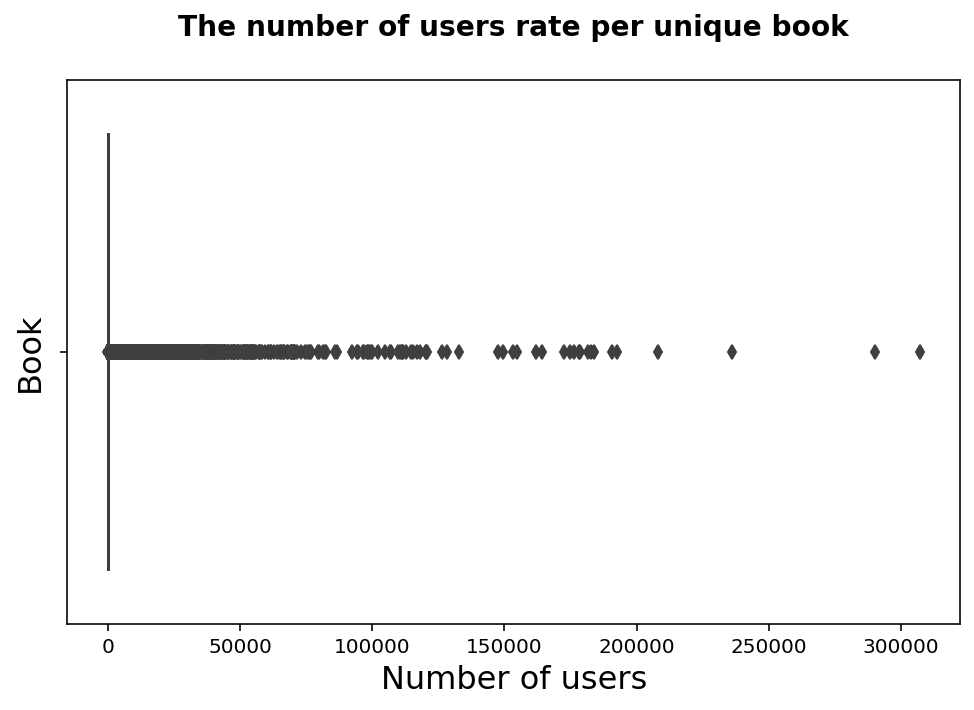

In [53]:
workrate_count = user_work_interactions.groupby('work_id')['rating'].size().reset_index().rename({"rating":"ratingcount"}, axis = 1)
workrate_count = workrate_count.sort_values(by="ratingcount",ascending = False)
plot_boxplot(workrate_count, "ratingcount", None, None, "The number of users rate per unique book", "Number of users", "Book", 'h')

In [54]:
workrate_count.describe()[["ratingcount"]]

,ratingcount
count,1.500100e+06
mean,6.931725e+01
std,1.143779e+03
min,1.000000e+00
25%,2.000000e+00
50%,5.000000e+00
75%,1.600000e+01
max,3.071360e+05


**Analysis: Majority of the books are being rated by less than 20 users with a range of 1 - 307136 users.**

This indicates that there is a wide range of books that are highly popular with about 30000 readers while some books are unpopular with only 1 user have rated and read.

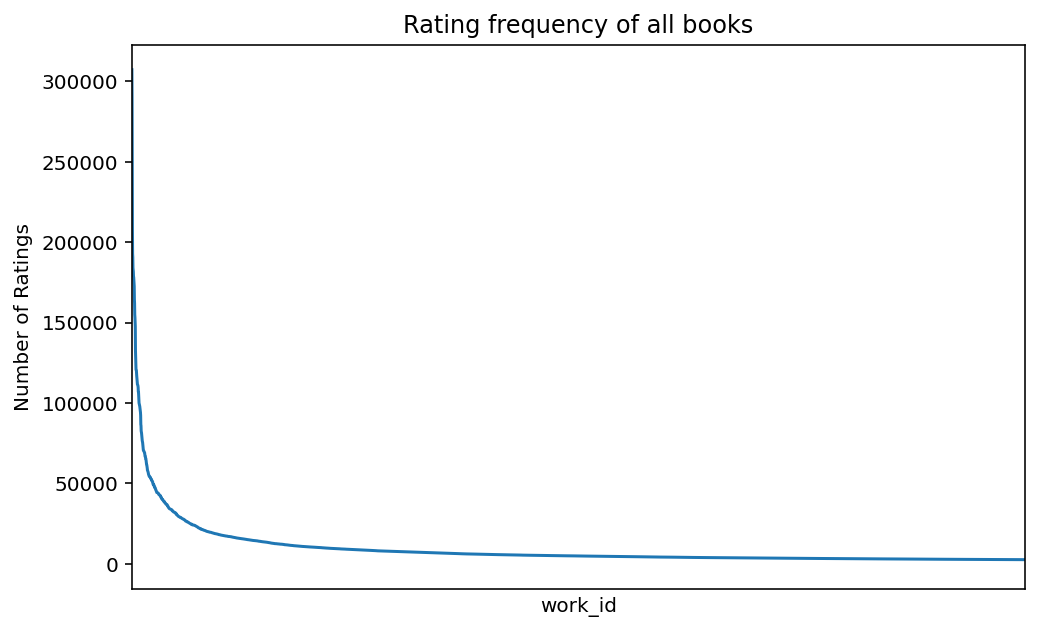

In [55]:
plt.figure(figsize = (8,5))
plt.plot(user_work_interactions.groupby("work_id").size().sort_values(ascending = False).values)
plt.xlim(0,5000)
plt.ylabel("Number of Ratings")
plt.xlabel("work_id")
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.title("Rating frequency of all books");

**Analysis: Distribution of the number of ratings per book is highly skewed.**

A small fraction of the books are highly rated by the users while a large proportion of the books have low number of ratings rated by the users. This illustrates the long tail as often seen in recommender system. 

### 5.4 Defining scope of user_work_interactions

Due to computational limitation, we will apply the following threshold and obtain a subset fraction of the full dataset:-
1. Threshold for ratings of a book required
2. Threshold for number of books rated by a user

### 5.4.1 Threshold for number of ratings for a book required

In [56]:
print(f"The number of user-book interactions is {user_work_interactions.shape[0]}")
print(f"The number of unique users is {user_work_interactions.user_id.nunique()}")
print(f"The number of unique books is {user_work_interactions.work_id.nunique()}")

The number of user-book interactions is 103982813
The number of unique users is 816368
The number of unique books is 1500100


In [57]:
user_work_interactions_model = pd.merge(user_work_interactions, workrate_count, on ="work_id", how = 'left')
print(f'The top 1% of the books has a minimum rating of {workrate_count.quantile(0.99)["ratingcount"]}')

The top 1% of the books has a minimum rating of 917.0


In [58]:
# Calculate the unique books of the books
print("The number of unique work_id that has a minimum rating of 917")
user_work_interactions_model[user_work_interactions_model.ratingcount>=917].work_id.nunique()

The number of unique work_id that has a minimum rating of 917


15014

In [59]:
# Applying the threshold of unique books
user_work_interactions_model = user_work_interactions_model[user_work_interactions_model.ratingcount>=917]

### 5.4.2 Threshold for number of books rated by a user

In [60]:
user_work_interactions_model.groupby(["user_id"]).size().describe()

count    793366.000000
mean         79.817795
std         111.830708
min           1.000000
25%          16.000000
50%          40.000000
75%          98.000000
max        3721.000000
dtype: float64

In [61]:
userbook_count_model = user_work_interactions_model.groupby(['user_id']).size().reset_index().rename({0:"bookcount_peruser"}, axis = 1)
user_work_interactions_model = pd.merge(user_work_interactions_model, userbook_count_model, on ="user_id", how = 'left')
print(f"The 25% of user has rated {userbook_count_model.quantile(0.25)['bookcount_peruser']} books")

The 25% of user has rated 16.0 books


In [62]:
# Calculate the unique users that have rated at least 16 books
print("The number of unique user_id that has rated at least 16 books is")
user_work_interactions_model[user_work_interactions_model.bookcount_peruser>=16].user_id.nunique()

The number of unique user_id that has rated at least 16 books is


603728

In [63]:
user_work_interactions_model = user_work_interactions_model[(user_work_interactions_model.bookcount_peruser>=16)]
user_work_interactions_model = user_work_interactions_model[["user_id", "work_id", "rating"]]

In [64]:
print(f"The number of user-book interactions model is {user_work_interactions_model.shape[0]}")
print(f"The number of unique users is {user_work_interactions_model.user_id.nunique()}")
print(f"The number of unique books is {user_work_interactions_model.work_id.nunique()}")

The number of user-book interactions model is 62079740
The number of unique users is 603728
The number of unique books is 15014


To reduce the memory overload, we have round down the average ratings and imply a stricter criteria to select books that a user like.

In [65]:
user_work_interactions_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62079740 entries, 0 to 63324724
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   user_id  int64  
 1   work_id  int64  
 2   rating   float64
dtypes: float64(1), int64(2)
memory usage: 1.9 GB


In [66]:
# To round down the average rating and change the dtype to int
user_work_interactions_model["rating"] = np.floor(user_work_interactions_model.rating)
user_work_interactions_model.rating = user_work_interactions_model.rating.astype(int)
user_work_interactions_model.rating.unique()

array([5, 4, 2, 3, 1])

In [67]:
user_work_interactions_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62079740 entries, 0 to 63324724
Data columns (total 3 columns):
 #   Column   Dtype
---  ------   -----
 0   user_id  int64
 1   work_id  int64
 2   rating   int32
dtypes: int32(1), int64(2)
memory usage: 1.6 GB


### 5.4.3 A subset fraction of the full dataset

In [68]:
# Sample a fraction of the main user_work_interactions
user_work_interactions_sample = user_work_interactions_model.sample(frac =  0.01, replace = False, random_state = 42)

A threshold of minimum 5 books rated by each user and the books have been rated at least 5 times is placed to ensure there is sufficient user book interactions when performing train-test-split.

#### 5.4.3.1 Threshold for users rating a book

In [69]:
print(f"The number of user-book interactions sample is {user_work_interactions_sample.shape[0]}")
print(f"The number of unique users is {user_work_interactions_sample.user_id.nunique()}")
print(f"The number of unique books is {user_work_interactions_sample.work_id.nunique()}")

The number of user-book interactions sample is 620797
The number of unique users is 304133
The number of unique books is 15014


In [70]:
workrate_count_sample = user_work_interactions_sample.groupby("work_id")["rating"].size().reset_index().rename({"rating":"ratingcount"}, axis = 1)
workrate_count_sample.describe()

,work_id,ratingcount
count,1.501400e+04,15014.000000
mean,1.162498e+07,41.347875
std,1.404432e+07,102.826665
min,8.700000e+01,1.000000
25%,1.222786e+06,12.000000
50%,3.354334e+06,18.000000
75%,1.898148e+07,34.000000
max,5.704416e+07,2917.000000


In [71]:
user_work_interactions_sample = pd.merge(user_work_interactions_sample, workrate_count_sample, on ="work_id", how = 'left')
print("The number of unique books after applying this threshold is")
user_work_interactions_sample[user_work_interactions_sample.ratingcount>=5].work_id.nunique()

The number of unique books after applying this threshold is


14893

In [72]:
# Applying the threshold on the subset of sample
user_work_interactions_sample = user_work_interactions_sample[(user_work_interactions_sample.ratingcount>=5)]

#### 5.4.3.2 Threshold for number of books rated by a user

In [73]:
bookcount_peruser_sample = user_work_interactions_sample.groupby(["user_id"]).size().reset_index().rename({0:"bookcount_peruser"}, axis = 1)
bookcount_peruser_sample.describe()

,user_id,bookcount_peruser
count,304032.000000,304032.000000
mean,292058.949976,2.040440
std,206924.973464,1.665916
min,0.000000,1.000000
25%,128598.750000,1.000000
50%,262782.500000,1.000000
75%,402425.500000,2.000000
max,876127.000000,38.000000


In [74]:
user_work_interactions_sample = pd.merge(user_work_interactions_sample, bookcount_peruser_sample, on ="user_id", how = 'left')
print("The number of unique users after applying this threshold is")
user_work_interactions_sample[user_work_interactions_sample.bookcount_peruser>=5].user_id.nunique()

The number of unique users after applying this threshold is


22859

In [75]:
# Applying the threshold on the subset of sample
user_work_interactions_sample = user_work_interactions_sample[user_work_interactions_sample.bookcount_peruser>=5]
user_work_interactions_sample = user_work_interactions_sample[["user_id", "work_id", "rating"]]

In [76]:
print(f"The number of user-book interactions sample is {user_work_interactions_sample.shape[0]}")
print(f"The number of unique users is {user_work_interactions_sample.user_id.nunique()}")
print(f"The number of unique books is {user_work_interactions_sample.work_id.nunique()}")

The number of user-book interactions sample is 149756
The number of unique users is 22859
The number of unique books is 14376


### 5.5 Summary

The majority of the books present in this dataset are as followed:-
* Genre - fiction with poetry being the least.
* The number of books in a series - about 3 books with a range from 0 to 738 books (excluding book editions).
* Book editions - less than 10 book editions with a range of 1-3676 book editions.
* Number of pages - 150-350 pages with some book having 0 pages that are either Audio CD, ebook or no information while some books such as religious book or dictionary having more than 300 thousand pages.
* Year of book published - There is an increasing trend in the books published from 1950 to recent years(21st century). There are books that are published prior to BC that are found to be reflective in other websites such as Amazon, while some books that are beyond the data collection year (2017), which could possibly be a typo.
* Book language type - undefined and english books.
* Book format types - paperback, undefined, hardcover and ebook.
* Book publisher are undefined. The publisher having more than 10 thousand books in goodreads are smashwords edition, harlequin and createspace.

In goodreads website, the majority of the books present in this dataset have the following characteristics:-
* An average rating of 4.0 with a range between 1.0 to 5.0
* The top 5 books that have the highest rating counts also has the highest total reviews count, which coincide with the findings that the first four books are listed as the top 100 bestselling books of all time and these top 10 books have been filmed into a movie [[1]](https://www.theguardian.com/news/datablog/2012/aug/09/best-selling-books-all-time-fifty-shades-grey-compare).
* Majority of book authors have an average rating of 4.0 with a range between 1.0 to 5.0
* The top 4 authors that have the highest rating counts also has the highest total reviews count coincide with the findings that the first four authors have bestselling books. All the top 10 authors that have highest ratings counts or highest total reviews count have books that are filmed in movies.

For the user book interactions, the books have the following details:-
* A significant proportion of the books rated are not reviewed by the users.
* There is an outlier in which a user has rated more than 35000 books, which will be removed.
* Majority of the users rated the books less than 150 books with some users rated more than 7500 to 17000 books. More than 10000 books read per user is possible depending on the accumulative number of years the user has read, the number of pages of the book read, and the speed the user read assuming the user read finish the books before they rated any of the books.
* Majority of user have rated the book with an average rating of 4.0 and a range between 1.0 to 5.0
* Majority of the books are being rated by less than 20 users with a range of 1 - 307136 users. This indicates that there is a wide range of books that are highly popular with about 30000 readers while some books are unpopular with only 1 user have rated and read.

Due to computational limitation, threshold for ratings of a book required and number of books rated by a user are applied prior to obtain a subset fraction of the full dataset for further analysis. This subset fraction is then selected with more than 5 books rated by each user and the books have been rated at least 5 times to ensure sufficient user book interactions when performing train-test-split.

## Exporting Data

In [77]:
#Placed the # to refrain from executing
#user_work_interactions.to_parquet("../data/user_work_interactions_clean.parquet", compression = 'gzip')
#booklist_worktitle.to_parquet("../data/booklist_worktitle.parquet", compression = 'gzip')
#user_work_interactions_model.to_parquet("../data/user_work_interactions_model_int.parquet", compression = 'gzip')
#user_work_interactions_sample.to_parquet("../data/user_work_interactions_sample_int.parquet", compression = 'gzip')

## References

[1] "The top 100 bestselling books of all time: how does Fifty Shades of Grey compare?," *Guardian News and Media Limited*, 2016. [Online]. Available:https://www.theguardian.com/news/datablog/2012/aug/09/best-selling-books-all-time-fifty-shades-grey-compare#data [Accessed: June 07, 2021].